# XGBoost

Let's learn about a very popular package for gradient boosting called `XGBoost`.

## What we will accomplish

In this notebook we will:
- Introduce the `XGBoost` package and point to the package installation process,
- Discuss what `XGBoost` is and why we use it over `sklearn` and
- Show how to implement gradient boosting regression in `XGBoost`:
    - Demonstrate `XGBoost` early stopping.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

## What is `XGBoost`?

While gradient boosting approximates gradient descent in a function space, XGBoost works like Newton-Raphson.  It uses a second order Taylor approximation of the loss function.  For squared error the Hessian is constant, so only needs to be computed once.

While we implemented this algorithm using `sklearn`, another very popular package for gradient boosting is `XGBoost` which stands for eXtreme Gradient Boosting. This particular package is often utilized in winning data science competitions, which likely led to its increase in popularity.

### Why `XGBoost`?

Why do so many people like using `XGBoost` over `sklearn`'s `GradientBoostingRegressor` and `GradientBoostingClassifier`? In comparison to `sklearn`'s implementation `XGBoost`'s code for fitting gradient boosting models is much faster and tends to perform better than `sklearn`. It even offers the capability for your model to be trained in parallel, which `sklearn` does not currently offer for gradient boosting.

## Implementing gradient boosting regression in `XGBoost`

With this motivation in mind, let's learn how to implement the same regression functionality we did with `sklearn` in the previous notebook. We will provide information on how to run gradient boosting classification and expand on the `XGBoost` syntax in the homework.

In [2]:
## Data

fea_access=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='ACCESS')
fea_stores=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='STORES')
fea_restaurants=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='RESTAURANTS')
fea_assistance=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='ASSISTANCE')
fea_insecurity=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='INSECURITY')
fea_taxes=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='TAXES')
fea_local=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='LOCAL')
fea_health=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='HEALTH')
fea_socioeconomic=pd.read_excel('data/FoodEnvironmentAtlas.xlsx',sheet_name='SOCIOECONOMIC')

In [3]:
list(fea_insecurity.columns)

['FIPS',
 'State',
 'County',
 'FOODINSEC_12_14',
 'FOODINSEC_15_17',
 'CH_FOODINSEC_14_17',
 'VLFOODSEC_12_14',
 'VLFOODSEC_15_17',
 'CH_VLFOODSEC_14_17']

In [4]:
## combined dataframe

fea1 = pd.merge(fea_access.iloc[:,0:4], fea_health.iloc[:,0:5], on=['FIPS','State','County'], how='inner')
fea2 = pd.merge(fea1, fea_stores, on=['FIPS','State','County'], how='inner')
fea = pd.merge(fea2, fea_socioeconomic, on=['FIPS','State','County'], how='inner')

fea_clean=fea.copy()
fea_clean=fea.dropna()


In [5]:
fea.head()

,FIPS,State,County,LACCESS_POP10,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,GROC11,GROC16,PCH_GROC_11_16,GROCPTH11,...,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,18428.439685,11.4,13.0,5,3,-40.000000,0.090581,...,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0
1,1003,AL,Baldwin,35210.814078,9.8,10.4,27,29,7.407407,0.144746,...,0.043343,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0
2,1005,AL,Barbour,5722.305602,13.6,18.4,6,4,-33.333333,0.219370,...,0.087409,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0
3,1007,AL,Bibb,1044.867327,11.1,14.8,6,5,-16.666667,0.263794,...,0.030548,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0
4,1009,AL,Blount,1548.175559,11.4,14.1,7,5,-28.571429,0.121608,...,0.031402,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0


In [6]:
## First make our data set
#np.random.seed(220)
#X = np.linspace(-2,2,200)
#y = X**2 + np.random.randn(200)

## Data from 
#X=np.array(fea_access['LACCESS_POP10'].drop('NaN')/fea_access['LACCESS_POP10'].max()) #Population, low access to store, 2010 (count)
#y=np.array(fea_health['PCT_DIABETES_ADULTS13']/fea_health['PCT_DIABETES_ADULTS13'].max()) #Adult diabetes rate, 2013 (percent)


#X=np.array(fea_clean['LACCESS_POP10']/fea_clean['LACCESS_POP10'].max()) #Population, low access to store, 2010 (count)
X=np.array(fea_clean['POVRATE15']/fea_clean['POVRATE15'].max())
y=np.array(fea_clean['PCT_DIABETES_ADULTS13']/fea_clean['PCT_DIABETES_ADULTS13'].max()) #Adult diabetes rate, 2013 (percent)


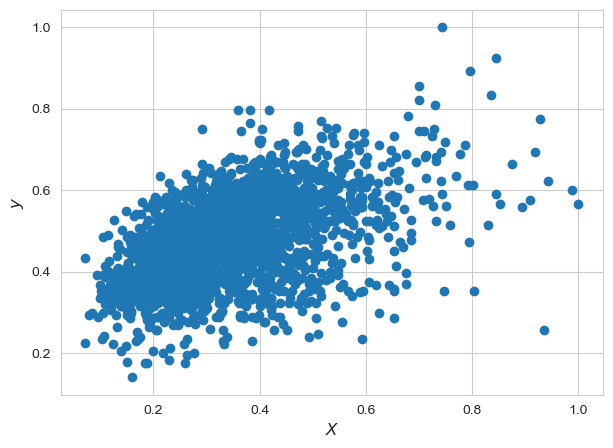

In [7]:
## Visualize the training data
plt.figure(figsize=(7,5))
plt.scatter(X,y)
plt.xlabel("$X$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.show()

One way to make a gradient boosting regressor in `XGBoost` is to use `XGBRegressor`, <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor">https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor</a>.

In [8]:
## import xgboost
import xgboost

In [9]:
## Let's recreate our learning_rate comparison

### Create an XGBRegressor object
### learning_rate=.1, max_depth=1, n_estimators=10
xgb_reg1 = xgboost.XGBRegressor(learning_rate=.1,
                                   max_depth=1,
                                   n_estimators=10)


## fit it
xgb_reg1.fit(X.reshape(-1,1), 
               y)
    #When you use reshape(-1, 1) , you are asking numpy to reshape your array with 
    #1 column and as many rows as necessary to accommodate the data

### Create an XGBRegressor object
### learning_rate=1, max_depth=1, n_estimators=10
xgb_reg2 = xgboost.XGBRegressor(learning_rate=1,
                                  max_depth=1,
                                   n_estimators=10)


## fit it
xgb_reg2.fit(X.reshape(-1,1), 
               y)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

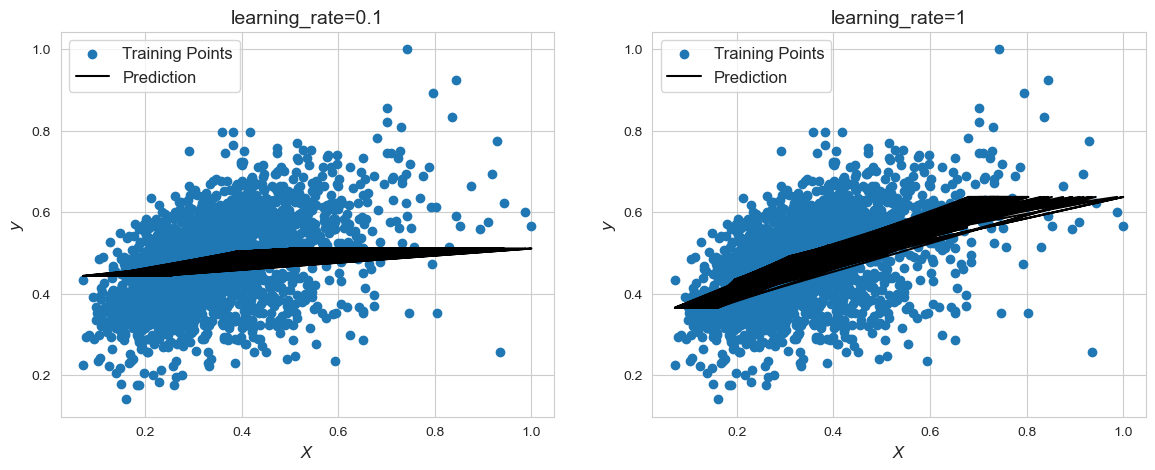

In [10]:
fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].scatter(X,y,label='Training Points')
ax[0].plot(X, xgb_reg1.predict(X.reshape(-1,1)), 'k',label="Prediction")
ax[0].set_title("learning_rate=0.1", fontsize=14)
ax[0].legend(fontsize=12)
ax[0].set_xlabel("$X$", fontsize=12)
ax[0].set_ylabel("$y$", fontsize=12)

ax[1].scatter(X,y,label='Training Points')
ax[1].plot(X, xgb_reg2.predict(X.reshape(-1,1)), 'k',label="Prediction")
ax[1].set_title("learning_rate=1", fontsize=14)
ax[1].legend(fontsize=12)
ax[1].set_xlabel("$X$", fontsize=12)
ax[1].set_ylabel("$y$", fontsize=12)

plt.show()

A nice feature of `xgboost`'s model is that it automatically records the performance at each training step on a validation set, provided we give the model the validation set.

In [11]:
## Here I will generate a validation set because the data are randomly generated
## in practice you would need to split the data
X_val = np.linspace(-2,2,200)
y_val = X_val**2 + np.random.randn(200)

In [12]:
## make an XGBRegressor object
## n_estimators = 500, max_depth = 1, learning_rate = .1
xgb_reg = xgboost.XGBRegressor(n_estimators=500,
                          max_depth=1,
                          learning_rate=.1)

## fit the model, including an eval_set
xgb_reg.fit(X.reshape(-1,1), y, eval_set=[(X_val.reshape(-1,1), y_val)])

[0]	validation_0-rmse:1.72743
[1]	validation_0-rmse:1.72688
[2]	validation_0-rmse:1.72596
[3]	validation_0-rmse:1.72582
[4]	validation_0-rmse:1.72493
[5]	validation_0-rmse:1.72520
[6]	validation_0-rmse:1.72444
[7]	validation_0-rmse:1.72468
[8]	validation_0-rmse:1.72291
[9]	validation_0-rmse:1.72334
[10]	validation_0-rmse:1.72305
[11]	validation_0-rmse:1.72397
[12]	validation_0-rmse:1.72251
[13]	validation_0-rmse:1.72357
[14]	validation_0-rmse:1.72258
[15]	validation_0-rmse:1.71942
[16]	validation_0-rmse:1.71939
[17]	validation_0-rmse:1.72031
[18]	validation_0-rmse:1.71754
[19]	validation_0-rmse:1.71651
[20]	validation_0-rmse:1.71717
[21]	validation_0-rmse:1.71683
[22]	validation_0-rmse:1.71453
[23]	validation_0-rmse:1.71527
[24]	validation_0-rmse:1.71550
[25]	validation_0-rmse:1.71347
[26]	validation_0-rmse:1.71299
[27]	validation_0-rmse:1.71414
[28]	validation_0-rmse:1.71238
[29]	validation_0-rmse:1.71238
[30]	validation_0-rmse:1.71339
[31]	validation_0-rmse:1.71276
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
## demonstrate .evals_result()
xgb_reg.evals_result()

{'validation_0': OrderedDict([('rmse',
               [1.727433604574505,
                1.7268849994760245,
                1.7259591596511743,
                1.7258206351074168,
                1.7249324733768698,
                1.725195786926282,
                1.7244448794191216,
                1.7246793207793212,
                1.7229131754876632,
                1.7233426948463344,
                1.723050936834348,
                1.723972113551403,
                1.7225125598099071,
                1.723572656356814,
                1.7225789207228317,
                1.7194231533089568,
                1.719390371365191,
                1.7203057983820962,
                1.7175350143299535,
                1.7165143326195902,
                1.7171665182010771,
                1.7168303154969626,
                1.7145304107963564,
                1.7152659509057464,
                1.7155025877867407,
                1.71346935202197,
                1.712993688968021

In [14]:
## get the 'rmse'
xgb_reg.evals_result()['validation_0']['rmse']

[1.727433604574505,
 1.7268849994760245,
 1.7259591596511743,
 1.7258206351074168,
 1.7249324733768698,
 1.725195786926282,
 1.7244448794191216,
 1.7246793207793212,
 1.7229131754876632,
 1.7233426948463344,
 1.723050936834348,
 1.723972113551403,
 1.7225125598099071,
 1.723572656356814,
 1.7225789207228317,
 1.7194231533089568,
 1.719390371365191,
 1.7203057983820962,
 1.7175350143299535,
 1.7165143326195902,
 1.7171665182010771,
 1.7168303154969626,
 1.7145304107963564,
 1.7152659509057464,
 1.7155025877867407,
 1.71346935202197,
 1.7129936889680215,
 1.7141405671705543,
 1.7123813571453042,
 1.7123765083868279,
 1.7133911189373872,
 1.712764895085243,
 1.7132855343174576,
 1.711813222180603,
 1.711649849153679,
 1.7124921467108982,
 1.7112025257157943,
 1.7113947401188658,
 1.7110411903210654,
 1.711766386642303,
 1.7106622020491402,
 1.7107347257438383,
 1.7103389836139828,
 1.7109697152956194,
 1.7109186279703776,
 1.7100003099211663,
 1.7103178415007203,
 1.709495735873483,
 1.71

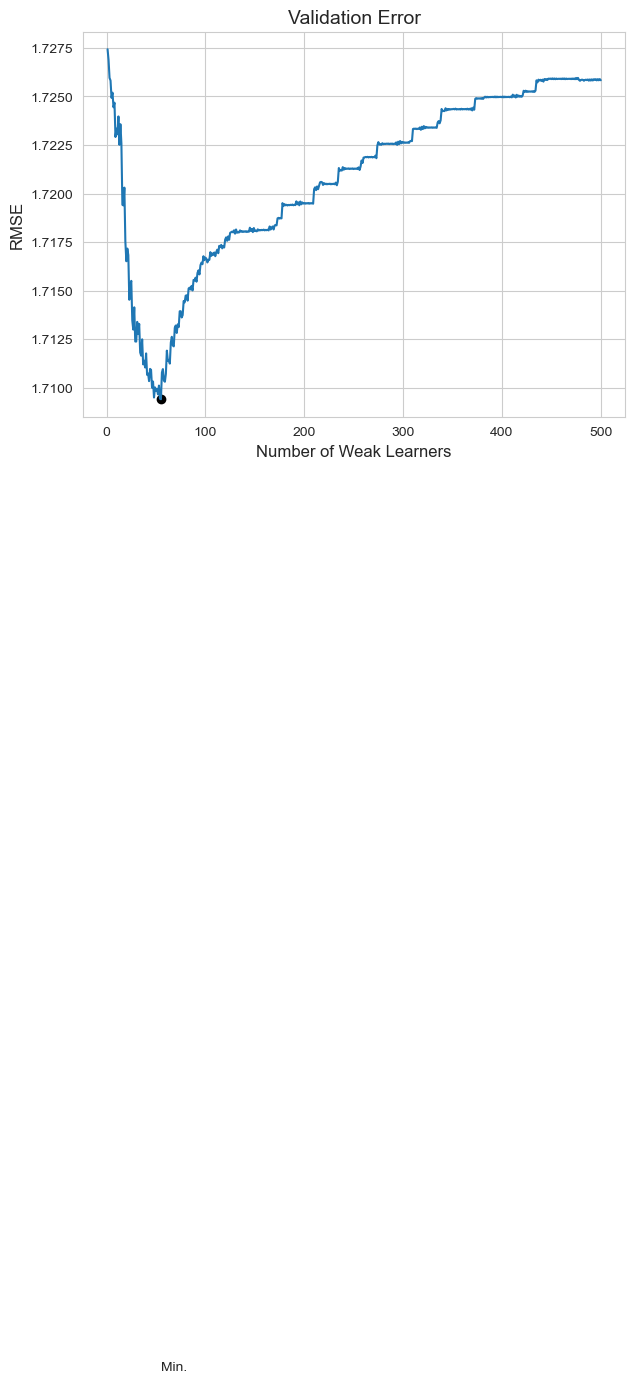

In [15]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'])
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Min.", fontsize=10)

plt.title("Validation Error", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

Further, `XGBoost` allows us to implement early stopping without having to write our own code to do so. We just have to include an `early_stopping_rounds` argument during the `fit` step.

In [16]:
## same xgb_reg as before
xgb_reg = xgboost.XGBRegressor(n_estimators = 500,
                                  max_depth = 1,
                                  early_stopping_rounds = 10,
                                  learning_rate = .1)


## Now show off early_stopping_rounds with eval_set
xgb_reg.fit(X.reshape(-1,1), y,
                   eval_set=[(X_val.reshape(-1,1), y_val)])

[0]	validation_0-rmse:1.72743
[1]	validation_0-rmse:1.72688
[2]	validation_0-rmse:1.72596
[3]	validation_0-rmse:1.72582
[4]	validation_0-rmse:1.72493
[5]	validation_0-rmse:1.72520
[6]	validation_0-rmse:1.72444
[7]	validation_0-rmse:1.72468
[8]	validation_0-rmse:1.72291
[9]	validation_0-rmse:1.72334
[10]	validation_0-rmse:1.72305
[11]	validation_0-rmse:1.72397
[12]	validation_0-rmse:1.72251
[13]	validation_0-rmse:1.72357
[14]	validation_0-rmse:1.72258
[15]	validation_0-rmse:1.71942
[16]	validation_0-rmse:1.71939
[17]	validation_0-rmse:1.72031
[18]	validation_0-rmse:1.71754
[19]	validation_0-rmse:1.71651
[20]	validation_0-rmse:1.71717
[21]	validation_0-rmse:1.71683
[22]	validation_0-rmse:1.71453
[23]	validation_0-rmse:1.71527
[24]	validation_0-rmse:1.71550
[25]	validation_0-rmse:1.71347
[26]	validation_0-rmse:1.71299
[27]	validation_0-rmse:1.71414
[28]	validation_0-rmse:1.71238
[29]	validation_0-rmse:1.71238
[30]	validation_0-rmse:1.71339
[31]	validation_0-rmse:1.71276
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

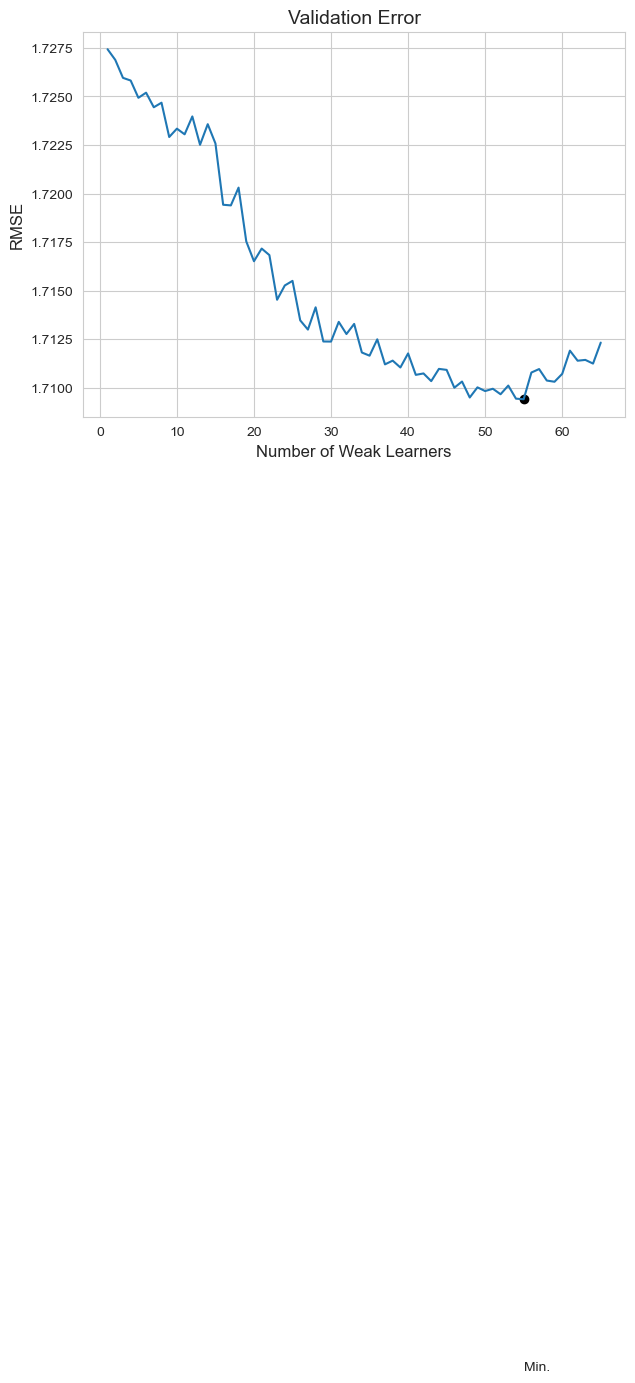

In [17]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'])
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Min.", fontsize=10)

plt.title("Validation Error", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

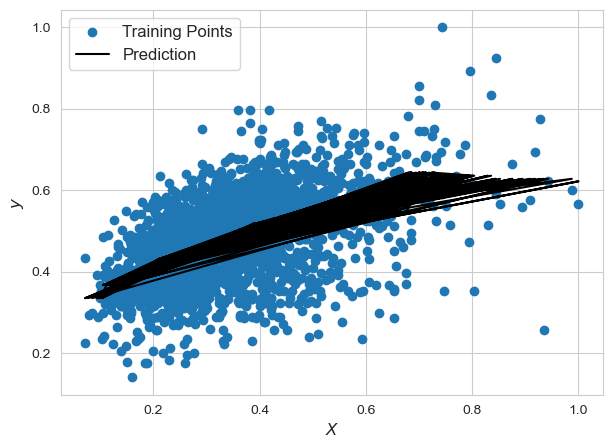

In [18]:
xgb_reg = xgboost.XGBRegressor(n_estimators = 220,
                                  max_depth = 1,
                                  learning_rate = .1)
xgb_reg.fit(X.reshape(-1,1), y)

plt.figure(figsize=(7,5))

plt.scatter(X,y,label='Training Points')
plt.plot(X, xgb_reg.predict(X.reshape(-1,1)), 'k',label="Prediction")
plt.legend(fontsize=12)
plt.xlabel("$X$", fontsize=12)
plt.ylabel("$y$", fontsize=12)

plt.show()

Here we have scratched the surface of what `XGBoost` can do. To learn more about the package check out the gradient boosting `Practice Problems` as well as the `XGBoost` documentation, <a href="https://xgboost.readthedocs.io/en/latest/index.html">https://xgboost.readthedocs.io/en/latest/index.html</a>.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023. Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)